In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import OpenAIEmbeddings
import pandas as pd
from tqdm import tqdm
import json


In [2]:
# CSV 파일 불러오기
df = pd.read_csv("hanja.csv")  # 파일 경로를 여기에 입력

df

,main_sound,level,hanja,meaning,radical,strokes,total_strokes
0,가,7급Ⅱ,家,"[[['집'], ['가']]]",宀,7,10
1,가,7급,歌,"[[['노래'], ['가']]]",欠,10,14
2,가,5급Ⅱ,價,"[[['값'], ['가']]]",人,13,15
3,가,5급,加,"[[['더할'], ['가']]]",力,3,5
4,가,5급,可,"[[['옳을'], ['가']]]",口,2,5
...,...,...,...,...,...,...,...
5973,희,특급,豨,"[[['돼지'], ['희']]]",豕,7,14
5974,희,특급,餼,"[[['보낼'], ['희']]]",食,10,19
5975,희,특급,橲,"[[['나무이름'], ['희']]]",木,12,16
5976,힐,1급,詰,"[[['꾸짖을'], ['힐']]]",言,6,13


In [ ]:
# JSON 파일을 파이썬 변수로 불러오기
with open("data/text-embedding-3-small.json", "r", encoding="utf-8") as f:
    embeddings = json.load(f)

In [4]:
type(embeddings)

dict

In [5]:
len(embeddings)

6023

In [8]:
# 'hanja'와 'radical' 컬럼만 추출
hanjas = df['hanja'].dropna().unique()
radicals = df['radical'].dropna().unique()

In [9]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import random


def calculate_roc_for_hanja_radical_pairs(df, embeddings):
    # 긍정적 쌍(실제 한자-부수 관계) 및 부정적 쌍(무작위 쌍) 생성
    similarities = []
    y_true = []
    positive_pairs = []
    
    # 실제 한자-부수 쌍 추출 (긍정적 케이스)
    valid_rows = df.dropna(subset=['hanja', 'radical'])
    
    for _, row in valid_rows.iterrows():
        hanja = row['hanja']
        radical = row['radical']
        
        # 임베딩이 있는지 확인
        if hanja in embeddings and radical in embeddings:
            # 코사인 유사도 계산 - sklearn 함수 사용
            hanja_vector = np.array(embeddings[hanja]).reshape(1, -1)
            radical_vector = np.array(embeddings[radical]).reshape(1, -1)
            
            similarity = cosine_similarity(hanja_vector, radical_vector)[0][0]
            
            similarities.append(similarity)
            y_true.append(1)  # 실제 쌍은 1로 레이블
            positive_pairs.append((hanja, radical))
    
    # 무작위 한자-부수 쌍 생성 (부정적 케이스)
    hanjas_with_embeddings = [h for h in hanjas if h in embeddings]
    radicals_with_embeddings = [r for r in radicals if r in embeddings]
    
    random.seed(42)
    
    negative_count = 0
    max_attempts = len(positive_pairs) * 5
    attempts = 0
    
    while negative_count < len(positive_pairs) and attempts < max_attempts:
        random_hanja = random.choice(hanjas_with_embeddings)
        random_radical = random.choice(radicals_with_embeddings)
        
        # 이미 실제 쌍인 경우 건너뛰기
        if (random_hanja, random_radical) not in positive_pairs:
            hanja_vector = np.array(embeddings[random_hanja]).reshape(1, -1)
            radical_vector = np.array(embeddings[random_radical]).reshape(1, -1)
            
            similarity = cosine_similarity(hanja_vector, radical_vector)[0][0]
            
            similarities.append(similarity)
            y_true.append(0)  # 무작위 쌍은 0으로 레이블
            negative_count += 1
        
        attempts += 1
    
    # ROC 커브 및 AUC 계산
    y_scores = np.array(similarities)
    y_true = np.array(y_true)
    
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    return fpr, tpr, roc_auc, thresholds

## ROC curve

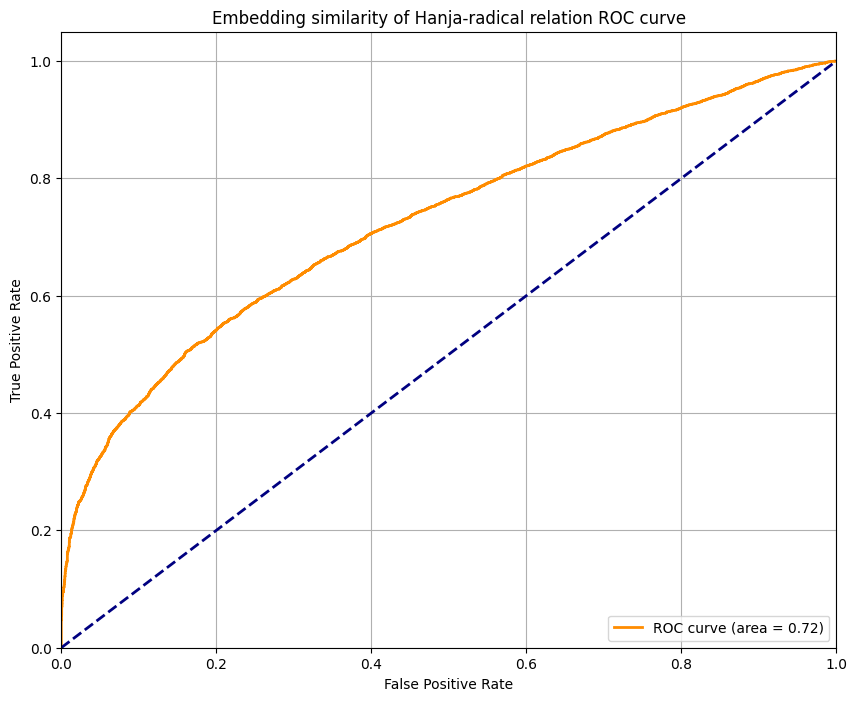

최적 임계값: 0.3983
이 임계값에서의 TPR: 0.5515, FPR: 0.2076
ROC 커브의 AUC 점수: 0.7245


In [32]:
# ROC 커브 계산
fpr, tpr, roc_auc, thresholds = calculate_roc_for_hanja_radical_pairs(df, embeddings)

# ROC 커브 시각화
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Embedding similarity of Hanja-radical relation ROC curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 최적 임계값 찾기
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"최적 임계값: {optimal_threshold:.4f}")
print(f"이 임계값에서의 TPR: {tpr[optimal_idx]:.4f}, FPR: {fpr[optimal_idx]:.4f}")
# AUC 값 출력
print(f"ROC 커브의 AUC 점수: {roc_auc:.4f}")

In [33]:
def calculate_precision_recall_at_k(df, embeddings, k_values=[1, 3, 5, 10]):
    # 한자별 실제 부수 매핑 구성
    hanja_to_radical = {}
    valid_rows = df.dropna(subset=['hanja', 'radical'])
    
    for _, row in valid_rows.iterrows():
        hanja = row['hanja']
        radical = row['radical']
        if hanja in embeddings and radical in embeddings:
            hanja_to_radical[hanja] = radical
    
    # 모든 부수의 임베딩 벡터를 모음
    radicals_with_embeddings = [r for r in df['radical'].dropna().unique() if r in embeddings]
    radical_embeddings = np.array([embeddings[r] for r in radicals_with_embeddings])
    
    # 결과 저장용 일반 딕셔너리
    results = {k: {'precision': [], 'recall': []} for k in k_values}
    
    # 각 한자에 대해 계산
    for hanja, true_radical in hanja_to_radical.items():
        # 한자 임베딩
        hanja_embedding = np.array(embeddings[hanja]).reshape(1, -1)
        
        # 모든 부수와의 유사도 계산
        similarities = cosine_similarity(hanja_embedding, radical_embeddings)[0]
        
        # 유사도 기준 내림차순 정렬된 인덱스
        top_indices = np.argsort(similarities)[::-1]
        
        # 각 k에 대해 정확도와 재현율 계산
        for k in k_values:
            top_k_indices = top_indices[:k]
            top_k_radicals = [radicals_with_embeddings[idx] for idx in top_k_indices]
            
            # 예측된 top-k 부수에 실제 부수가 포함되어 있는지 확인
            hit = true_radical in top_k_radicals
            
            # 정확도(Precision@k) 계산
            precision_at_k = 1.0/k if hit else 0.0
            
            # 재현율(Recall@k) 계산 - 단일 부수이므로 hit이면 1, 아니면 0
            recall_at_k = 1.0 if hit else 0.0
            
            results[k]['precision'].append(precision_at_k)
            results[k]['recall'].append(recall_at_k)
    
    # 평균 계산
    for k in k_values:
        avg_precision = np.mean(results[k]['precision'])
        avg_recall = np.mean(results[k]['recall'])
        results[k]['avg_precision'] = avg_precision
        results[k]['avg_recall'] = avg_recall
    
    return results

# 계산 실행
k_values = [1, 3, 5, 10]
precision_recall_results = calculate_precision_recall_at_k(df, embeddings, k_values)

# 결과 출력
print("한자-부수 예측 성능:")
for k in k_values:
    print(f"Precision@{k}: {precision_recall_results[k]['avg_precision']:.4f}")
    print(f"Recall@{k}: {precision_recall_results[k]['avg_recall']:.4f}")

한자-부수 예측 성능:
Precision@1: 0.1253
Recall@1: 0.1253
Precision@3: 0.0703
Recall@3: 0.2108
Precision@5: 0.0522
Recall@5: 0.2610
Precision@10: 0.0335
Recall@10: 0.3352
